# __Classical Controllers Demonstration__

Getting the script set up. Remember to run:
1) activate .
2) instantiate

In [1]:
using DrWatson
@quickactivate "dare"

using Plots
using LinearAlgebra
using FFTW
using ControlSystems
using ReinforcementLearning
using IntervalSets
using CUDA

include(srcdir("Classical_Control.jl"));
include(srcdir("Power_System_Theory.jl"));
include(srcdir("Classical_Control_Plots.jl"));
include(srcdir("nodeconstructor.jl"));
include(srcdir("env.jl"));

_______________________________________________________________________________
## Parameters - Time simulation

Here we set the simulation time step, which is the inverse of both the sampling and switching frequencies.

In [2]:
# Parameters - Time simulation
Timestep = 75; #time step in μs ~ 100μs => 10kHz, 50μs => 20kHz, 20μs => 50kHz
t_final = 2; #time in seconds, total simulation run time

#_______________________________________________________________________________
# Environment Calcs

Ts = Timestep*1e-6;
t = 0:Ts:t_final; # time

f_cntr = 1/Ts; # Hz, Sampling frequency of controller ~ 15 kHz -> 50kHz

_______________________________________________________________________________
## Classical Source Settings

We have to specify the number of classically controllable sources their power parameters. Each source represents a three-phase half-bridge power electronic converter, which is electricallly modelled as an ideal voltage source connected to a network through a filter. 

All sources may be given a delay in integer values of the simulation time interval. Typically the delay can be considered to be 1.5 sampling time steps. While the controller is automatically designed for 1.5 x Ts, the half is not something that can be simulated in this toolbox.

Each source may be run in one of a number of modes. The mode selection is stored in a dictionary found within the mutable struct (a julia object). If you don't feel like typing in the full string, you may specify the mode by just passing throught the corresponding index.<br>

>1. "Voltage Control Mode" - controls the output voltage to nominal (e.g. 230 V rms)<br>
>2. "PQ Control Mode" - controls the output real and imaginary powers to nominal<br>
>3. "Droop Control Mode" - a higher level voltage control mode with dynamic power balancing<br>
>4. "Synchronverter Mode" - mimics a virtual synchronous generator<br>
>5. "Swing Mode" - no control, just creates a sinusoidal output voltage

The controllers typically follow a nested control strategy with an inner PI current control loop, followed by an outer PI voltage control mode. The Kp and Ki values are automatically tuned through the LoopShaping method. Some of the modes may have additional tuning parameters. For example, the Droop control mode and Synchronverter Mode have droop coefficients which are tuned given the maximum drop in frequency and maximum drop in rms voltage. For the Synchronverter mode we also have the time constants which determine the virtual inertia of the inverter.

In [3]:
#_______________________________________________________________________________
# Setting up the Sources

num_sources = 2;

Source = Source_Controller(t_final, f_cntr, num_sources, delay = 1);

#=
    Typical values for the frequency droop are a 100% increase in power for a
    frequency decrease between 3% and 5% (from nominal values)
=#

Source.Δfmax = 0.03*50/100; # The drop in frequency, Hz, which will cause a 100% increase in active power
Source.ΔEmax = 0.05*230/100; # The drop in rms voltage, which will cause a 100% decrease in reactive power
τ = 1.0;

Source.τv = τ; # time constant of the voltage loop
Source.τf = τ;

Mode_Keys = collect(keys(Source.Modes));

Source_Initialiser(Source, Mode_Keys[1], num_source = 1, Prated = 150e3);
Source_Initialiser(Source, Mode_Keys[1], num_source = 2, Prated = 100e3);

_______________________________________________________________________________
## Environment (Electrical Network) Settings

Now we have to tell our simulation what the network looks like. For example, the connectivity (graph topology), the cable impedances, and the loads.

Currently, there is only one option available. Two sources connected to a load. The load has an inductive and a capacitive component that can be specified separately.

In [4]:
#_______________________________________________________________________________
# Circuit Elements Calcs

num_loads = 1;

# Load 1 Impedance
Vo_rms = 230; # rms output voltage

SL1 = 75e3; # VA, 3-ph Apparent Power
pf1 = 0.6; # power factor
SL2 = 50e3; # VA, 3-ph Apparent Power
pf2 = -0.9999; # power factor

# Network Cable Impedances
l = 0.5 # length in km
Lt1 = 0.0024*l # H, line inductance
Lt2 = 0.0024*l
Rt1 = 0.222*l # Ω, line resistance
Rt2 = 0.222*l

#_______________________________________________________________________________
# State space representation
A, B, C, D, B2, D2 = Two_Sources_One_Load(Source, Vo_rms, SL1, pf1, SL2, pf2, Lt1, Lt2, Rt1, Rt2)

Env = Environment(t_final, Ts, A, B, C, D, num_sources, num_loads)
Env.V_poc_loc = [3 4; 11 12; 19 20]; # ID's at which nodes the are sources located
Env.I_poc_loc = [5 6; 13 14; 21 22];
Env.I_inv_loc = [1 2; 9 10; 17 18];

_______________________________________________________________________________
## Running the Time Domain Simulation

Note that half way through the simulation the power set point of the 2nd source changes. 

In [5]:

for i in 1:Env.N-1

    #Measurements(Env); # measuring powers, and rms values

    # Control System _______________________________________________________

    if t[i] > t_final/2
        num_source = 2 # changing the power set points of the 2nd source
        #Source.pq0_set[num_source, 1] = -50e3 # W, Real Power
        Source.pq0_set[num_source, 2] = 50e3 # VAi, Imaginary Power
    end

    #-----------------------------------------------------------------------

    Action = Classical_Control(Source, Env); # calculating the actions to be performed by the sources.

    # System Dynamics ______________________________________________________

    Evolution(Env, Action);

end


_______________________________________________________________________________
## Plotting the Results

In [9]:
#Plot_I_dq0(10, 5000, Source, Env, num_source = 2)

#Plot_V_dq0(10, 5000, Source, Env, num_source = 2)

#Inst_Vout_Vref(0, 50, Source, Env, num_node = 2, num_source = 2)

#Inst_Iout_Iref(0, 50, Source, Env, num_source = 2, num_node = 2)

#Plot_PLL(0, 500, Source, Env, num_source = 2, ph = 2)

#Plot_Irms(0, 5000, Env, num_node = 2)

#Plot_Vrms(0, 5000, Env, Source, num_node = 1, num_source = 1)
Plot_Vrms(0, 5000, Source, num_source = 2)

#Plot_Real_Imag_Active_Reactive(10, 5000, Env, Source, num_node = 1, num_source = 1)
#Plot_Real_Imag_Active_Reactive(10, 5000, Env, Source, num_node = 2, num_source = 2)

#Plot_fft(0, 1, Env, Source, num_node = 2, num_source = 2)

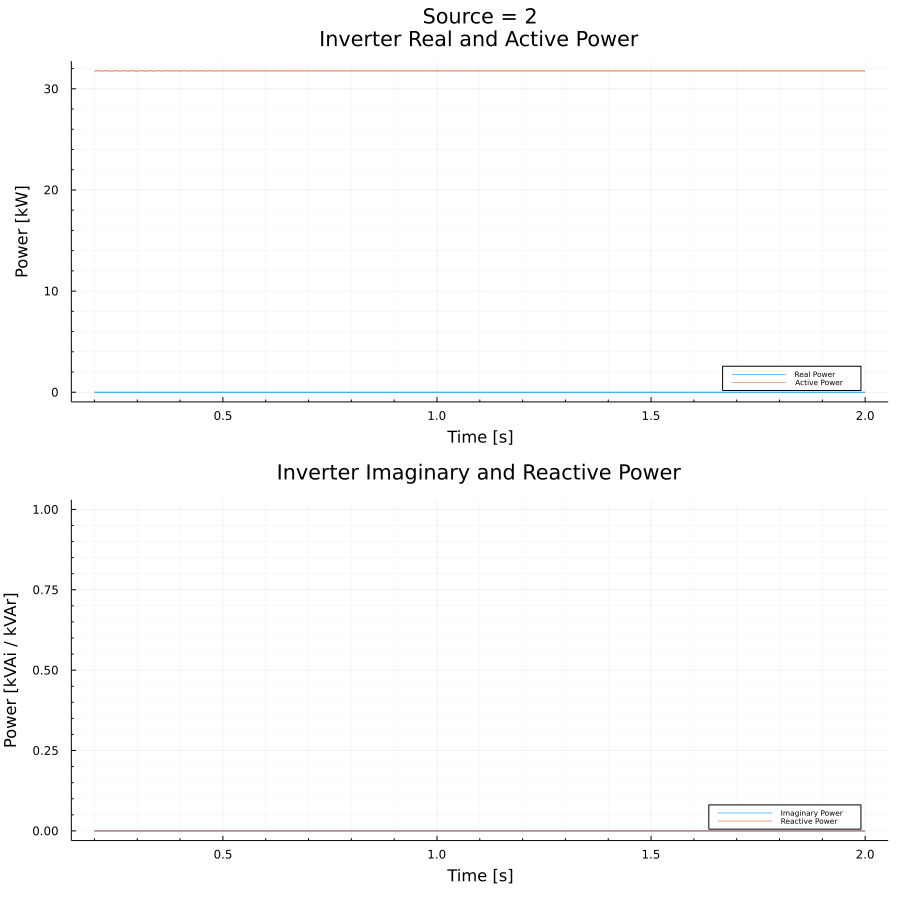

In [10]:
Plot_Real_Imag_Active_Reactive(10, 5000, Source, num_source = 2)